# Part III: Generate KDEs and obtain persistence diagrams

- Compute the four cardinal directional distance transforms (distance to the closest cell wall along a given cardinal direction) for the cross section.
- Compute a KDE with a grid of stepsize `stepsize`
- Correct KDE boundaries: treat cell walls and nuclei as steep walls.
- Compute sub or superlevel persistence

Notice that the KDE itself is not saved, as it can easily computed again if necessary.
- Saving it would be quite expensive in the long run

In [1]:
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tifffile as tf
from glob import glob
import os
from scipy import ndimage, stats

from KDEpy import FFTKDE
import gudhi as gd
import json

import utils
from importlib import reload

# Load all general data

- Same setup as in the previous notebooks

Detected 2937 cells
Detected 1365 nuclei


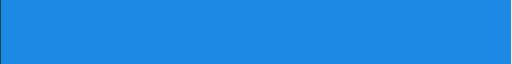

In [6]:
wong = ['#d81b60', '#1e88e5', '#ffc107', '#004d40']
levels = ['sub', 'sup']
pows2 = 2**np.arange(20) + 1
fs = 15
bw = 25
PP = 6
stepsize = 3
pp = 0
nuclei_mask_cutoff = 1

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
ksrc = '../kde/'
sample = 'D2'

ksrc += sample + os.sep

#wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
label, cellnum = ndimage.label(tf.imread(wsrc + sample + '_dams.tif').astype(bool), ndimage.generate_binary_structure(2,1))
print('Detected',cellnum,'cells')

lnuc, nnuc = ndimage.label(tf.imread(nsrc + sample + '_EDT.tif') < nuclei_mask_cutoff, ndimage.generate_binary_structure(2,1))
print('Detected',nnuc,'nuclei')

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col = 0)
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv', index_col=-1)
cell_nuc = pd.read_csv(ksrc + sample + '_nuclei_limits.csv')
#cell_nuc.loc[cell_nuc['n_bot'] == 1, 'n_bot'] = 0
#cell_nuc.loc[cell_nuc['n_top'] == 61, 'n_top'] = 65

tcumsum = np.hstack(([0], np.cumsum(metatrans['cyto_number'].values)))

transcriptomes = np.asarray(metatrans['gene'])
translocs = [None for i in range(len(transcriptomes))]
for i in range(len(transcriptomes)):
    filename = tsrc + sample + os.sep + 'location_corrected_D2_-_' + transcriptomes[i] + '.csv'
    translocs[i] = pd.read_csv(filename, header=None, names=['X', 'Y', 'Z'])
    translocs[i]['cidx'] = label[ translocs[i]['Y'], translocs[i]['X'] ]
    translocs[i]['nidx'] =  lnuc[ translocs[i]['Y'], translocs[i]['X'] ]

tlocs = pd.concat(translocs)

zmax = tlocs['Z'].max()+stepsize
zmin = tlocs['Z'].min()

foo = [ wong[-1], wong[-2] ] + np.repeat(wong[1], nnuc).tolist() + ['#f0f0f0']
cmap = ListedColormap(foo)
cmap

In [42]:
isrc = '..' + os.sep + 'infected_focus_summer24' + os.sep
isrc += sample + os.sep

Cells = utils.get_range_cell_values(isrc + 'infected_cells_ids.csv', metacell, startval=1)
Genes = utils.get_range_gene_values(isrc + 'genes_to_focus_infection.csv', transcriptomes, startval=0)

if (Cells is None) or (Genes is None):
    print('Make sure that the ID value is an integer')
    print('Or make sure that the specified file exists and is formatted correctly')

# Compute transcript weights for KDE

- If transcript is close to a border (cell wall or nucleus), it becomes heavier to then reflect the Gaussian "weight"
- Inspired from this thread in [crossvalidated](https://stats.stackexchange.com/questions/65866/good-methods-for-density-plots-of-non-negative-variables-in-r/).
- In this case, the weight variability is restrained: it will be at most `2`
- An unaffected transcript will have weight `1` instead.

In [9]:
if False:
    filename = ksrc + sample + '_border_weights.npy'
    if not os.path.isfile(filename):
        top, right, bottom, left = utils.cardinal_distance_transform(wall)
        wv = stats.norm.cdf(top[tlocs['Y'].values, tlocs['X'].values]+pp, loc=0, scale=bw)
        wv-= stats.norm.cdf(-bottom[tlocs['Y'].values, tlocs['X'].values]-pp, loc=0, scale=bw)
        
        wh = stats.norm.cdf(right[tlocs['Y'].values, tlocs['X'].values]+pp, loc=0, scale=bw) 
        wh-= stats.norm.cdf(-left[tlocs['Y'].values, tlocs['X'].values]-pp, loc=0, scale=bw)
        
        weight = 2-(wv*wh)
        np.save(filename, weight)
    
    weight = np.load(filename, allow_pickle=True)

![](https://raw.githubusercontent.com/ejamezquita/ejamezquita.github.io/main/mcarto/figs/D2_GLYMA_05G092200_1749_1748_distance_transform.jpg)

# Select a cell and then a gene

- Get a nice bounding box to just focus on a given cell `cidx`
- A tri-color image `cell` is produced, where
    - `0` is for nuclei and walls
    - `1` for other cytoplasm
    - `2` for the cytosol of the specified cell 
- Produce a regular grid for that box of stepsize `stepsize`
- The grid extends beyond the box by a factor `pad` to account for numerical overflows when the computing KDE
- Get the transcripts of the gene inside that cell

In [254]:
foo = metacell.loc[Cells]
foo[foo['nuclei_area'] > 0 ].sort_values(by='total_area')

,x0,x1,y0,y1,length,height,total_area,nuclei_area,cyto_area,c2t_area_ratio,number_nuclei,orig_comX,orig_comY,ndimage_comX,ndimage_comY,orig_cellID
ndimage_cellID,,,,,,,,,,,,,,,,
2161,7766,7938,11599,11772,172,173,16978,2003,14975,0.882024,1,7846.62,11671.26,7846.22,11671.09,2162
825,14737,14936,5989,6285,199,296,26017,62,25955,0.997617,0,14837.45,6129.80,14836.97,6129.56,826
787,5365,5572,5813,6054,207,241,26818,2139,24679,0.920240,1,5479.55,5936.68,5478.83,5936.20,788
1207,3412,3627,7589,7801,215,212,29045,3550,25495,0.877776,1,3516.59,7701.65,3516.06,7701.16,1207
1454,4379,4596,8638,8885,217,247,29930,1327,28603,0.955663,1,4484.10,8748.03,4483.63,8747.71,1455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722,5196,5683,9732,10634,487,902,209726,6930,202796,0.966957,1,5445.07,10184.86,5444.52,10184.33,1723
1701,8133,8687,9634,10281,554,647,214011,969,213042,0.995472,1,8419.83,9949.02,8419.10,9948.79,1702
366,6607,7131,3814,4527,524,713,215410,5423,209987,0.974825,1,6864.81,4170.33,6864.35,4169.82,367


In [277]:
PP = 6
cidx = 2529

cell, cextent = utils.get_cell_img(cidx, metacell, label, lnuc, nnuc, PP=PP, pxbar=True)
s_ = np.s_[ cextent[2]:cextent[3] , cextent[0]:cextent[1] ]
edt = ndimage.distance_transform_edt(label[s_] == cidx)

axes, grid, kdegmask, cgrid, outside_walls = utils.cell_grid_preparation(cidx, cell, label, cextent, zmax, stepsize, cell_nuc)
outw = outside_walls.copy().reshape( list(map(len, axes))[::-1], order='F')
zfactor = np.divide(  list(map(len, axes))[::-1][1:] , np.asarray(cell.shape) )
kbins = np.linspace(0, np.max(edt), 27)

cellhist = np.digitize(edt, kbins, right=True)
zoom = ndimage.zoom(cellhist, zfactor, mode='grid-constant', grid_mode=True)
zoom = (~outw)*np.tile(zoom, reps=(len(axes[-1]), 1,1))

peripherality = pd.DataFrame(index=range(1,len(kbins)))
peripherality['count'] =  ndimage.histogram(zoom, 1, len(kbins)-1, len(kbins)-1)

In [ ]:
tidx = 26
coords = translocs[tidx].loc[ translocs[tidx]['cidx'] == cidx , ['X','Y', 'Z'] ].values.T

kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(coords.T).evaluate(grid)
kde = kde[kdegmask]/(np.sum(kde[kdegmask])*(stepsize**len(coords)))
kde[outside_walls] = 0
kde = kde/(np.sum(kde)*(stepsize**len(coords)))
kde = kde.reshape( list(map(len, axes))[::-1], order='F')
kmax = kde.max()

In [278]:


peripherality['sum_'+transcriptomes[tidx]] = ndimage.sum_labels(kde, zoom, range(1, len(kbins)))
peripherality['mean_'+transcriptomes[tidx]] = peripherality['sum_'+transcriptomes[tidx]] / peripherality['count']
peripherality.head()

,count,sum_GLYMA_05G092200,mean_GLYMA_05G092200
1,30998,0.003811,1.229331e-07
2,33726,0.004838,1.434568e-07
3,31834,0.004793,1.505551e-07
4,31614,0.004721,1.493194e-07
5,30140,0.004280,1.420025e-07


In [257]:
peripherality.tail()

,count,sum_GLYMA_05G092200,mean_GLYMA_05G092200
12,3186,0.001747,5.482695e-07
13,2408,0.001274,5.291255e-07
14,1839,0.000960,5.218404e-07
15,1469,0.000756,5.149017e-07
16,764,0.000394,5.154347e-07


In [235]:
if metacell.loc[cidx, 'nuclei_area'] > 0:
    cc = gd.CubicalComplex(top_dimensional_cells = utils.get_level_filtration(kde, 'sub') )
    pers = cc.persistence(homology_coeff_field=2, min_persistence=1e-15)

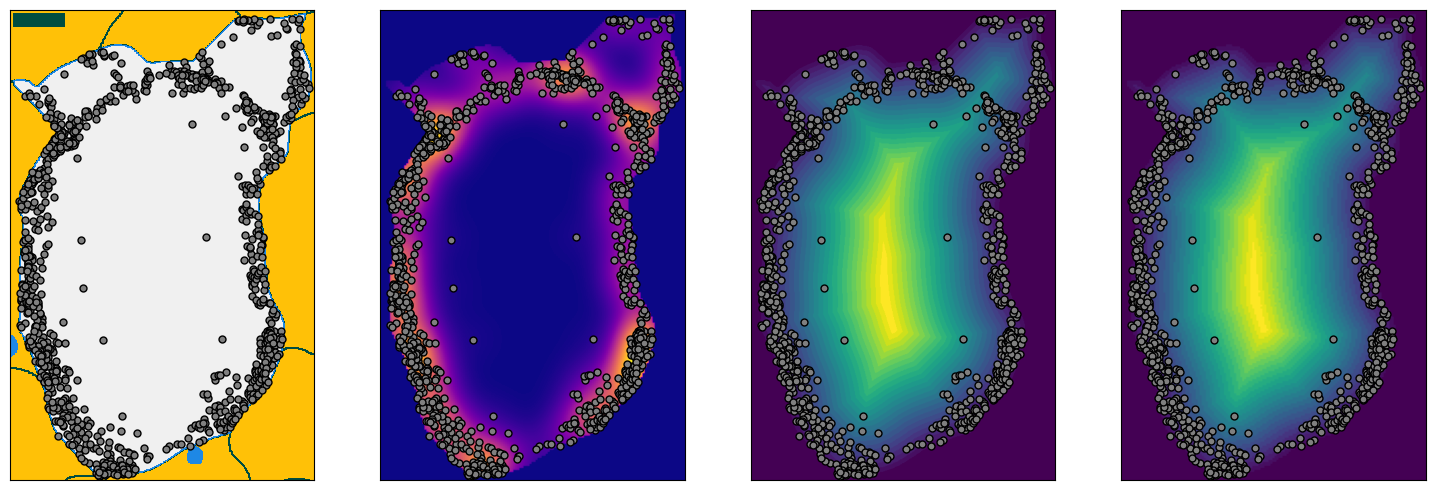

In [279]:
fig, ax = plt.subplots(1,4, figsize=(15,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j = 0

ax[0].imshow(cell+1, cmap=cmap, origin='lower', extent=cextent, vmin=0, vmax=nnuc+2);
ax[1].imshow(kde[10], origin='lower', cmap='plasma', vmin=0, vmax=kmax, extent=cextent);
ax[2].imshow(cellhist, origin='lower', cmap='viridis', vmin=0, extent=cextent);
ax[3].imshow(zoom[1], origin='lower', cmap='viridis', vmin=0, extent=cextent);

for j in range(len(ax)):
    ax[j].scatter(coords[0], coords[1], c='gray', marker='o', edgecolor='k', zorder=3, s=25, alpha=1);
    ax[j].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    ax[j].set_aspect('equal')

fig.tight_layout();

In [316]:
xs = np.linspace(0,1, len(peripherality))
ys = peripherality['mean_'+transcriptomes[tidx]].values

dys = np.gradient(ys, xs)
rgr = DecisionTreeRegressor(max_leaf_nodes=n_seg)
rgr.fit(xs.reshape(-1, 1), dys.reshape(-1, 1))
dys_dt = rgr.predict(xs.reshape(-1, 1)).flatten()
uq, idxs = np.unique(dys_dt, return_inverse=True)

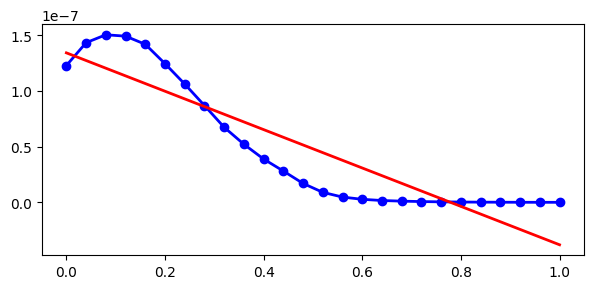

In [290]:
fig, ax = plt.subplots(1,1, figsize=(7,3), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j = 0

#ax[j].plot(range(len(peripherality)), peripherality['mean_'+transcriptomes[tidx]], lw=2, marker='o', c='b')

ax[j].plot([0,1], [b, m+b], c='r', lw=2);
#ax[j].plot([0,len(peripherality)-1], [b, (len(peripherality)-1)*m+b], c='r', lw=2);

In [334]:
filename = transcriptomes[tidx] + '_-_peripherality_c{:06d}.csv'.format(cidx)
peripherality.to_csv(filename, index=False)

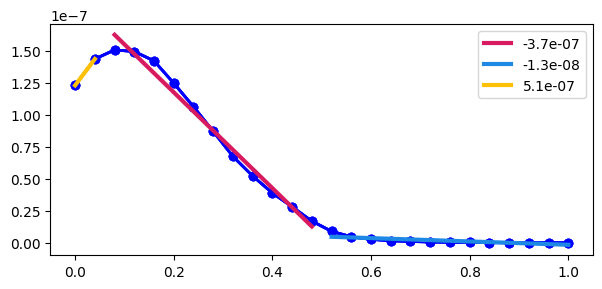

In [329]:
fig, ax0 = plt.subplots(1, 1, figsize=(7,3))

ys_sl = np.ones(len(xs)) * np.nan
for i in range(len(uq)):
    msk = idxs == i
    linregress = stats.linregress(xs[msk], ys[msk])
    ys_sl[msk] = linregress.slope*xs[msk] + linregress.intercept
    ax0.plot(np.linspace(0,1,len(peripherality)), peripherality['mean_'+transcriptomes[tidx]], lw=2, marker='o', c='b', zorder=1)
    
    ax0.plot([xs[msk][0], xs[msk][-1]], [ys_sl[msk][0], ys_sl[msk][-1]], color=wong[i], zorder=2, lw=3, label='{:.1e}'.format(linregress.slope))
    
ax0.legend()

In [324]:
lin_reg.coef_

array([[5.13090932e-07]])

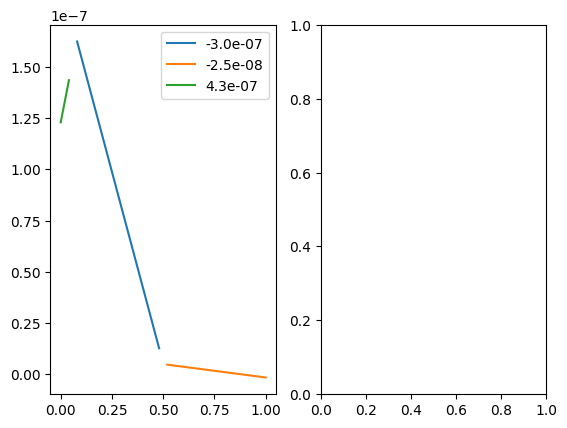

In [322]:
fig, (ax0, ax1) = plt.subplots(1, 2)

ys_sl = np.ones(len(xs)) * np.nan
for i,y in enumerate(uq):
    msk = dys_dt == y
    lin_reg = LinearRegression()
    lin_reg.fit(xs[msk].reshape(-1, 1), ys[msk].reshape(-1, 1))
    ys_sl[msk] = lin_reg.predict(xs[msk].reshape(-1, 1)).flatten()
    ax0.plot([xs[msk][0], xs[msk][-1]],[ys_sl[msk][0], ys_sl[msk][-1]], zorder=1, label='{:.1e}'.format(y))

ax0.legend()

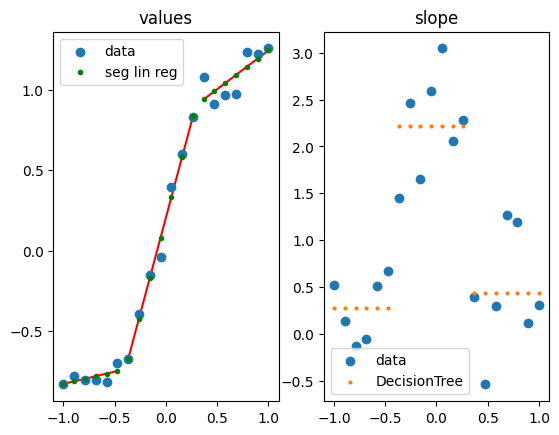

In [291]:
# https://stackoverflow.com/questions/29382903/how-to-apply-piecewise-linear-fit-in-python

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

# parameters for setup
n_data = 20

# segmented linear regression parameters
n_seg = 3

fig, (ax0, ax1) = plt.subplots(1, 2)

# example 1
#xs = np.sort(np.random.rand(n_data))
#ys = np.random.rand(n_data) * .3 + np.tanh(5* (xs -.5))

# example 2
xs = np.linspace(-1, 1, 20)
ys = np.random.rand(n_data) * .3 + np.tanh(3*xs)

dys = np.gradient(ys, xs)

rgr = DecisionTreeRegressor(max_leaf_nodes=n_seg)
rgr.fit(xs.reshape(-1, 1), dys.reshape(-1, 1))
dys_dt = rgr.predict(xs.reshape(-1, 1)).flatten()

ys_sl = np.ones(len(xs)) * np.nan
for y in np.unique(dys_dt):
    msk = dys_dt == y
    lin_reg = LinearRegression()
    lin_reg.fit(xs[msk].reshape(-1, 1), ys[msk].reshape(-1, 1))
    ys_sl[msk] = lin_reg.predict(xs[msk].reshape(-1, 1)).flatten()
    ax0.plot([xs[msk][0], xs[msk][-1]],
             [ys_sl[msk][0], ys_sl[msk][-1]],
             color='r', zorder=1)

ax0.set_title('values')
ax0.scatter(xs, ys, label='data')
ax0.scatter(xs, ys_sl, s=3**2, label='seg lin reg', color='g', zorder=5)
ax0.legend()

ax1.set_title('slope')
ax1.scatter(xs, dys, label='data')
ax1.scatter(xs, dys_dt, label='DecisionTree', s=2**2)
ax1.legend()

In [100]:
PP = 6
cidx = 433

s_ = (np.s_[max([0, metacell.loc[cidx, 'y0'] - PP]) : min([label.shape[0], metacell.loc[cidx, 'y1'] + PP])],
      np.s_[max([1, metacell.loc[cidx, 'x0'] - PP]) : min([label.shape[1], metacell.loc[cidx, 'x1'] + PP])])
extent = (s_[1].start, s_[1].stop, s_[0].start, s_[0].stop)


cell = label[s_].copy()
cell[ label[s_] > 0 ] = 0
cell[ label[s_] == cidx ] = nnuc + 1
cell[ lnuc[s_] > 0 ] = lnuc[s_][lnuc[s_] > 0]
cell[ label[s_] == 0 ] = -1


maxdims = ( cell.shape[1], cell.shape[0], zmax+stepsize) 
print('Maxdims:\t',maxdims)
axes, grid, gmask = utils.kde_grid_generator(stepsize=stepsize, maxdims=maxdims, pows2 = pows2, pad=1.5)
grid[:, :2] = grid[:, :2] + np.array([s_[1].start, s_[0].start])
cgrid = grid[gmask].copy()
cgrid[:,:2] = grid[gmask][:,:2] - np.array([s_[1].start, s_[0].start])

nuc_lims = cell_nuc.loc[ (cell_nuc['ndimage_ID'] == cidx), ['ndimage_ID','nuc_ID','N_inside','n_bot','n_top']]
outside_walls = cell[cgrid[:,1],cgrid[:,0]] < 1
outside_walls |= label[s_][cgrid[:,1] , cgrid[:,0]] != cidx

outs0 = outside_walls.copy().reshape( list(map(len, axes))[::-1], order='F')

foo = np.setdiff1d( np.unique(cell), nuc_lims['nuc_ID'].values)[:-1]
for v in foo:
    outside_walls |= cell[cgrid[:,1], cgrid[:,0]] == v

outs1 = outside_walls.copy().reshape( list(map(len, axes))[::-1], order='F')

for j in range(len(nuc_lims)):
    _, nidx, N_inside, n_bot, n_top = nuc_lims.iloc[j]
    if n_bot < n_top:
        thr_mask = (cgrid[:,2] >= n_bot) & (cgrid[:,2] <= n_top)
    else:
        thr_mask = (cgrid[:,2] <= n_top) | (cgrid[:,2] >= n_bot)

    outside_walls |= ((cell[cgrid[:,1],cgrid[:,0]] == nidx) & thr_mask)

outs2 = outside_walls.copy().reshape( list(map(len, axes))[::-1], order='F')

coords = translocs[tidx].values.T
print(transcriptomes[tidx], metatrans.iloc[tidx]['cyto_number'], sep='\t')

cmask = label[ coords[1], coords[0] ] == cidx
ccoords = coords[:, cmask ].copy()
print(cidx, ccoords.shape, np.unique(cell), sep='\t')

Maxdims:	 (298, 297, 64)
GLYMA_17G195900	736912
742	(5, 379)	[  -1    0  421 1366]


In [49]:
np.unique(cgrid[:,2])

array([ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48,
       51, 54, 57, 60, 63])

In [38]:
Cells

NameError: name 'Cells' is not defined

In [37]:
metacell

,x0,x1,y0,y1,length,height,total_area,nuclei_area,cyto_area,c2t_area_ratio,number_nuclei,orig_comX,orig_comY,ndimage_comX,ndimage_comY,orig_cellID
ndimage_cellID,,,,,,,,,,,,,,,,
1,0,17152,0,17152,17152,17152,114911591,36950,114874641,0.999678,0,7865.12,8160.49,7865.56,8160.76,1
2,8333,8935,1293,1979,602,686,222903,1351,221552,0.993939,1,8635.46,1576.65,8635.18,1577.03,2
3,8893,9151,1317,1598,258,281,42604,0,42604,1.000000,0,9013.47,1470.26,9013.07,1469.69,3
4,10790,11221,1337,1591,431,254,77463,0,77463,1.000000,0,10999.04,1460.48,10998.62,1459.99,4
5,7740,8048,1362,1823,308,461,86041,870,85171,0.989889,1,7894.78,1596.06,7894.19,1595.83,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,3828,4249,16197,16436,421,239,61860,0,61860,1.000000,0,4051.30,16319.91,4050.78,16319.31,2934
2934,4085,4567,16241,16650,482,409,127384,0,127384,1.000000,0,4338.51,16440.70,4337.88,16440.30,2935
2935,5199,5496,16267,16456,297,189,27989,0,27989,1.000000,0,5336.04,16367.01,5335.80,16366.57,2936


In [40]:
j = 0
_, nidx, N_inside, n_bot, n_top = nuc_lims.iloc[j]

print(n_bot < n_top)

False


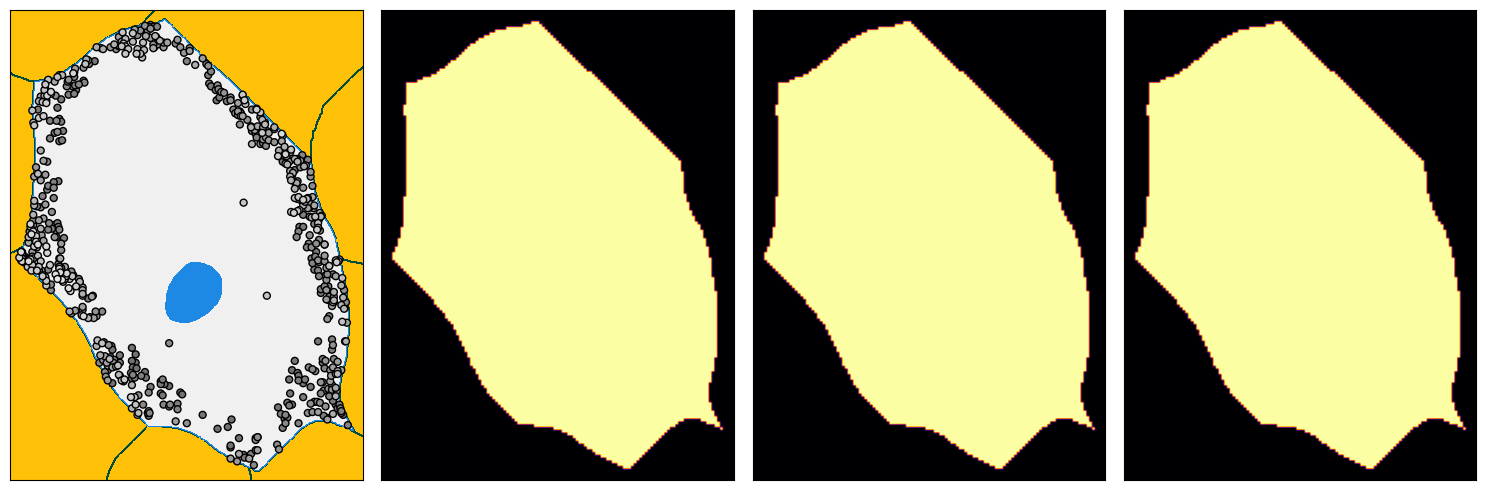

In [47]:
fig, ax = plt.subplots(1,4, figsize=(15,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j = 0

ax[0].imshow(cell+1, cmap=cmap, origin='lower', extent=extent, vmin=0, vmax=nnuc+2);
ax[0].scatter(ccoords[0], ccoords[1], c=ccoords[2], marker='o', cmap='Greys_r', edgecolor='k', zorder=3, s=25, vmin=1, vmax=60);
    
ax[1].imshow( np.max(~outs0, axis=0), cmap='inferno', origin='lower', extent=extent, vmin=0, vmax=1);
ax[2].imshow( np.max(~outs1, axis=0), cmap='inferno', origin='lower', extent=extent, vmin=0, vmax=1);
ax[3].imshow( np.max(~outs2, axis=0), cmap='inferno', origin='lower', extent=extent, vmin=0, vmax=1);

for j in range(len(ax)):
    ax[j].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    ax[j].set_aspect('equal')

fig.tight_layout();

# Compute, crop, and correct the KDE

- KDE is mainly sensitive to bandwidth value, and to kernel type to a lesser extent.
- Things are mathematically trickier whenever dealing with more than 1D (we're dealing with 3D in this case)
- There are several well-studied heuristics on how to choose the "best" bandwidth from the data alone.
    - An immediate problem is that most of the advanced heuristics are limited to 1D, but some tinkering can be done for [higher dimensions](https://github.com/tommyod/KDEpy/issues/81).
- In the end, we simply chose `bw = 10` since this is a small value relative to cell size (average side length of a cell is about 175px)
- We want a small bandwidth to highlight density changes across the cytosol within the same cell

### Actual computations

- KDE computed with `KDEpy`, which is surprisingly quick, [just like advertised](https://kdepy.readthedocs.io/en/latest/).
- For comparison we compute an unweighted KDE `uwkde`
- This KDE is then cropped and reweighted to remove the grid padding
- In reality, we want a weighted KDE `kde`, with weights as mentioned above
- It is also cropped and reweighted to remove grid padding
- But then we also remove anything outside the specified cytosol and reweigh again

![](https://raw.githubusercontent.com/ejamezquita/ejamezquita.github.io/main/mcarto/figs/D2_GLYMA_05G092200_1749_1748_3D_kde_correction.gif)

In [19]:
kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(ccoords.T).evaluate(grid)
kde = kde[gmask]/(np.sum(kde[gmask])*(stepsize**len(coords)))
kde[outside_walls] = 0

kde = kde/(np.sum(kde)*(stepsize**len(coords)))
kde = kde.reshape( list(map(len, axes))[::-1], order='F')
print(np.sum(kde)*(stepsize**len(coords)))
maxkde = np.max(kde)

0.9999999999999998


In [20]:
outs = outside_walls.reshape( list(map(len, axes))[::-1], order='F')

In [21]:
outs.shape

(22, 186, 153)

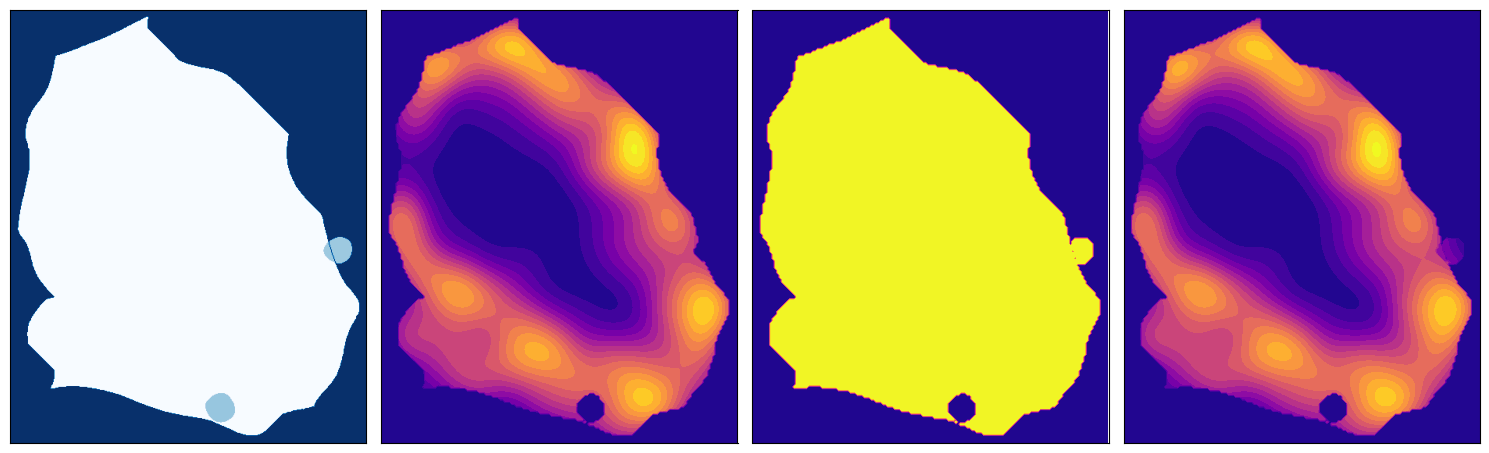

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(15,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax); j = 0

ax[0].imshow(cell, cmap='Blues_r', origin='lower', extent=extent);
ax[1].contourf(axes[0]+s_[1].start, axes[1]+s_[0].start, kde[7,:,:], 16, cmap='plasma', vmin=0, zorder=1, vmax=maxkde)
ax[2].contourf(axes[0]+s_[1].start, axes[1]+s_[0].start, np.max(~outs, axis=0), 16, cmap='plasma', vmin=0, zorder=1, vmax=1)
ax[3].contourf(axes[0]+s_[1].start, axes[1]+s_[0].start, np.max(kde, axis=0), 16, cmap='plasma', vmin=0, zorder=1, vmax=maxkde)

for j in range(len(ax)):
    #ax[j].scatter(ccoords[0], ccoords[1], c=ccoords[2], marker='o', cmap='Greys_r', edgecolor='k', zorder=3, s=25, vmin=1, vmax=60);
    ax[j].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    ax[j].set_aspect('equal')

fig.tight_layout();

# Cubical persistence

- Cubical persistence computed with [`gudhi`](https://gudhi.inria.fr/), which does a decent job whenever images are less than 1000 x 1000 px in size.
- Persistence computed directly on 3D images produced by the KDE
- Played with both sublevel and superlevel filtrations
- Probably we'll stick with superlevel later down the line, as it is intuitively easier to explain and visualize.

In [76]:
for level in levels:
    tdst = '..' + os.sep + level + 'level' + os.sep + sample + os.sep + transcriptomes[tidx] + os.sep
    filename = tdst + transcriptomes[tidx] + '_-_{}_p{}_s{}_bw{}_c{:06d}.json'.format(level,PP,stepsize,bw,cidx)
    if not os.path.isfile(filename):
        cc = gd.CubicalComplex(top_dimensional_cells = utils.get_level_filtration(kde, level) )
        pers = cc.persistence(homology_coeff_field=2, min_persistence=1e-15)
        print(filename)
        with open(filename, 'w') as f:
            json.dump(pers,f)

../sublevel/D2/GLYMA_05G092200/GLYMA_05G092200_-_sub_p6_s3_bw10_c000011.json


FileNotFoundError: [Errno 2] No such file or directory: '../sublevel/D2/GLYMA_05G092200/GLYMA_05G092200_-_sub_p6_s3_bw10_c000011.json'

In [266]:
cc = gd.CubicalComplex(top_dimensional_cells = utils.get_level_filtration(kde, 'sub') )
pers = cc.persistence(homology_coeff_field=2, min_persistence=1e-15)

In [267]:
bd = np.zeros((len(pers), 3), dtype=float)
for i in range(len(bd)):
    bd[i, 0] = pers[i][0]
    bd[i, 1:] = pers[i][1]
bd[ bd == np.inf] = maxkde

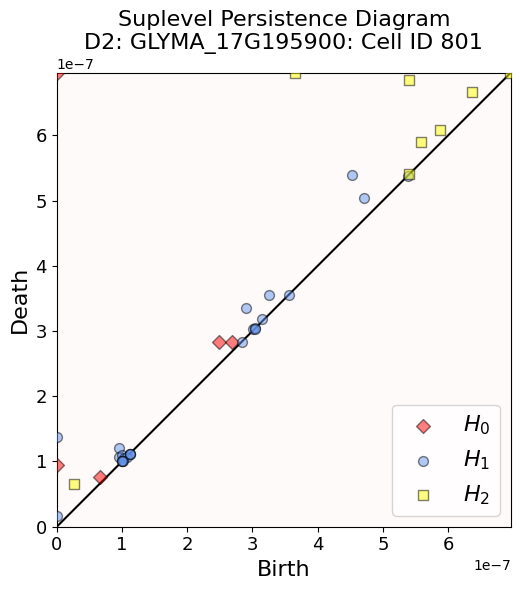

In [268]:
fs = 16; marker = ['D', 'o', 's']; color = ['red','cornflowerblue', 'yellow']
fig, ax = plt.subplots(1,1, figsize=(6,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i in range(bd.shape[1]):
    mask = bd[:,0] == i
    ax[0].scatter(bd[mask, 1], bd[mask, 2], label='$H_{}$'.format(i), marker=marker[i], 
                  c=color[i], s=50, linewidth=1, edgecolor='k', zorder=i+4, alpha=0.5)

ax[0].scatter([0, np.max(bd[:,1:])] , [np.max(bd[:,1:]), np.max(bd[:,1:])] , alpha=0)
ax[0].legend(loc='lower right', fontsize=fs)
ax[0].set_aspect(1)
ax[0].axline(xy1=(0,0), slope=1, c='k', zorder=1)
ax[0].tick_params(labelsize=fs-3)
ax[0].set_xlabel('Birth', fontsize=fs)
ax[0].set_ylabel('Death', fontsize=fs)
ax[0].margins(0)
ax[0].set_facecolor('snow')

title = '{}level Persistence Diagram\n{}: {}: Cell ID {}'.format(level.title(), sample, transcriptomes[tidx], metacell.loc[cidx, 'orig_cellID'])
ax[0].set_title(title, fontsize=fs)

fig.tight_layout()

# What if we just want to focus on a subset of cells and genes?

In [290]:
Levels = ['sup', 'sub']
BW = [10,5,20,25]
PP

6

In [291]:
all_files = True
for level in Levels:
    for bw in BW:
        filename = '..' + os.sep + '{}level'.format(level) + os.sep + sample + os.sep + transcriptomes[tidx] + os.sep 
        filename +='{}_-_{}_p{}_s{}_bw{}_c{:06d}.json'.format(transcriptomes[tidx], level, PP, stepsize, bw, cidx)
        if not os.path.isfile(filename):
            print('Missing', filename)
            all_files = False
all_files

Missing ../suplevel/D2/GLYMA_17G195900/GLYMA_17G195900_-_sup_p6_s3_bw5_c000800.json
Missing ../sublevel/D2/GLYMA_17G195900/GLYMA_17G195900_-_sub_p6_s3_bw5_c000800.json


False

In [278]:
glob('..' + os.sep + '*level' + os.sep + sample + os.sep + transcriptomes[tidx] + os.sep + '*c{:06d}.json'.format(cidx))

['../suplevel/D2/GLYMA_17G195900/GLYMA_17G195900_-_sup_p6_s3_bw30_c000800.json',
 '../suplevel/D2/GLYMA_17G195900/GLYMA_17G195900_-_sup_p6_s3_bw10_c000800.json',
 '../suplevel/D2/GLYMA_17G195900/GLYMA_17G195900_-_sup_p6_s3_bw15_c000800.json',
 '../suplevel/D2/GLYMA_17G195900/GLYMA_17G195900_-_sup_p6_s3_bw20_c000800.json',
 '../suplevel/D2/GLYMA_17G195900/GLYMA_17G195900_-_sup_p6_s3_bw25_c000800.json',
 '../sublevel/D2/GLYMA_17G195900/GLYMA_17G195900_-_sub_p6_s3_bw30_c000800.json',
 '../sublevel/D2/GLYMA_17G195900/GLYMA_17G195900_-_sub_p6_s3_bw25_c000800.json',
 '../sublevel/D2/GLYMA_17G195900/GLYMA_17G195900_-_sub_p6_s3_bw20_c000800.json',
 '../sublevel/D2/GLYMA_17G195900/GLYMA_17G195900_-_sub_p6_s3_bw10_c000800.json',
 '../sublevel/D2/GLYMA_17G195900/GLYMA_17G195900_-_sub_p6_s3_bw15_c000800.json']